# Length of stay in ED

Look at the length of stay in emergency department for all cases.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [2]:
# read in data files
datadir = "/home/eulalio/BMI212/2019_data/"

adt_file = datadir + "traige_cohort_2019_adt.csv"
csn_file = datadir + "cohort_2019_csns.csv"
results_file = datadir + "results_gbw.csv"
labels_file = datadir + "triage_cohort_2019_all_labels.csv"


full_adt = pd.read_csv(adt_file)
csns = pd.read_csv(csn_file)
results = pd.read_csv(results_file)
labels = pd.read_csv(labels_file)


In [3]:
# filter down to csns in our cohort - should be 41,654 csns
adt = full_adt[full_adt.pat_enc_csn_id_coded.isin(csns.pat_enc_csn_id_coded)]

adt.pat_enc_csn_id_coded.nunique()

41654

# Size of train/val/test

In [5]:
adt.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min'],
      dtype='object')

In [6]:
# add year of admit
adt['effective_year'] = pd.DatetimeIndex(adt['effective_time_jittered_utc']).year
adt.head()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,seq_num_in_enc,seq_num_in_bed_min,effective_year
1,JCdd1c51,131239256613,Inpatient,Acute Care (Assessment or intervention q4-8),Discharge,Cystic Fibrosis Adult,NaN,Private,2017-09-22 21:00:00 UTC,2017-09-22 22:11:00 UTC,9,1.0,2017
2,JCe3d69a,131073413173,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Interventional Radiology,NaN,Ward,2015-02-11 22:08:00 UTC,2015-02-11 22:08:00 UTC,32,1.0,2015
3,JCdbe7ee,131263117876,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Thoracic Surgery,NaN,Ward,2019-02-12 01:12:00 UTC,2019-02-12 01:12:00 UTC,6,1.0,2019
4,JCe4f9bd,131193869303,Inpatient,Intermediate Care - With Cardiac Monitor,Transfer In,Thoracic Surgery,NaN,Intermediate Intensive Care Unit (IICU-Telemetry),2016-09-06 23:01:00 UTC,2016-09-06 23:01:00 UTC,34,1.0,2016
5,JCccbebb,131217959883,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Gastroenterology,NaN,Semi-Private,2017-01-31 21:24:00 UTC,2017-01-31 21:24:00 UTC,13,1.0,2017


In [4]:
# ** takes a long time to run **
# change the effective time to datetime since read in from csv
adt.effective_time_jittered_utc = pd.to_datetime(adt.effective_time_jittered_utc)

# sort by csn and time
adt.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)

/home/eulalio/snap/jupyter/common/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
# add the admit time column from the prediction results csv to the adt csv
adt_admit = adt.merge(labels, how='left')
adt_admit.head()

adt_admit.admit_time = pd.to_datetime(adt_admit.admit_time)

adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'inpatient_data_id_coded',
       'label_max24', 'admit_time', 'admit_label', 'label_24hr_recent',
       'label_12hr_recent', 'has_admit_label', 'first_label',
       'first_label_time_since_admit', 'acute_to_critical_label',
       'critical_to_acute_label'],
      dtype='object')

In [6]:
# do we still have all of the CSNs? - YES
adt_admit.pat_enc_csn_id_coded.nunique()

41654

In [7]:
# assumes that the data frame is sorted by time!!

# compute the time before admit for each of these events
adt_admit['time_before_admit'] = adt_admit.apply(lambda x: x.admit_time - x.effective_time_jittered_utc, axis=1)
adt_admit.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,time_before_admit
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00 UTC,...,2015-01-02 01:01:00+00:00,0.0,0,0.0,1,0.0,0,0,0,0 days 07:51:00
1,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00 UTC,...,2015-01-02 01:01:00+00:00,0.0,0,0.0,1,0.0,0,0,0,0 days 00:29:00
2,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00 UTC,...,2015-01-02 01:01:00+00:00,0.0,0,0.0,1,0.0,0,0,0,0 days 00:29:00
3,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00 UTC,...,2015-01-02 01:01:00+00:00,0.0,0,0.0,1,0.0,0,0,0,0 days 00:12:00
4,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00 UTC,...,2015-01-02 01:01:00+00:00,0.0,0,0.0,1,0.0,0,0,0,0 days 00:12:00


In [8]:
# mark the events with some labels that make things easier later

# **assumes dataframe is sorted by time

# mark whether previous entry had pat class Emergency Services
adt_admit['prev_emerg'] = adt_admit.pat_class.shift() == 'Emergency Services'
# mark whether current event has pat class Inpatient
adt_admit['curr_inpatient'] = adt_admit.pat_class == 'Inpatient'
# mark whether current event is continued csn as previous
adt_admit['continued'] = adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift())

# find our cases by taking the AND of these columns
cols = ['prev_emerg', 'curr_inpatient', 'continued']
adt_admit['first_ip'] = adt_admit[cols].all(axis=1)

adt_admit.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00 UTC,...,1,0.0,0,0,0,0 days 07:51:00,False,False,False,False
1,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00 UTC,...,1,0.0,0,0,0,0 days 00:29:00,True,False,True,False
2,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00 UTC,...,1,0.0,0,0,0,0 days 00:29:00,True,False,True,False
3,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00 UTC,...,1,0.0,0,0,0,0 days 00:12:00,True,False,True,False
4,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00 UTC,...,1,0.0,0,0,0,0 days 00:12:00,True,False,True,False


In [9]:
# find the first emergency services pat_class for each csn
change_pat = adt_admit[~adt_admit.pat_class.eq(adt_admit.pat_class.shift())]
change_pat.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00 UTC,...,1,0.0,0,0,0,0 days 07:51:00,False,False,False,False
6,JCe78a06,131062667066,Inpatient,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (PAMF),NaN,Intermediate Intensive Care Unit (IICU-Telemetry),2015-01-02 01:01:00+00:00,2015-01-02 01:02:00 UTC,...,1,0.0,0,0,0,0 days 00:00:00,True,True,True,True
20,JCd1c19e,131062745090,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-03 01:56:00+00:00,2015-01-03 01:56:00 UTC,...,1,0.0,0,0,0,0 days 03:57:00,False,False,False,False
28,JCd1c19e,131062745090,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,NaN,Private,2015-01-03 05:53:00+00:00,2015-01-03 06:03:00 UTC,...,1,0.0,0,0,0,0 days 00:00:00,True,True,True,True
45,JCd91eb2,131062747648,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 01:10:00+00:00,2015-01-01 01:10:00 UTC,...,1,0.0,0,0,0,0 days 07:14:00,False,False,False,False


In [10]:
# lots of these still have many events - meaning they moved around a lot
change_pat.groupby('pat_enc_csn_id_coded').anon_id.count().value_counts()

2    40135
3      956
4      513
5       36
6        9
8        3
1        2
Name: anon_id, dtype: int64

In [11]:
# keep the event with pat_class == Emergency Services, that occurs before the first inpatient event
# check to make sure that we're looking at the same CSN between both events
# don't take any where admit ocurred before ER event - happens when people move around a lot (ER -> Inpatient -> ER -> Inpatient)
keep_visits = change_pat[(change_pat.pat_class == 'Emergency Services') & 
                         (change_pat.shift(-1).first_ip) &
                         (change_pat.shift(-1).pat_enc_csn_id_coded == change_pat.pat_enc_csn_id_coded) & 
                         (change_pat.time_before_admit >= timedelta(days=0))] # remove this for now
keep_visits.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00 UTC,...,1,0.0,0,0,0,0 days 07:51:00,False,False,False,False
20,JCd1c19e,131062745090,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-03 01:56:00+00:00,2015-01-03 01:56:00 UTC,...,1,0.0,0,0,0,0 days 03:57:00,False,False,False,False
45,JCd91eb2,131062747648,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 01:10:00+00:00,2015-01-01 01:10:00 UTC,...,1,0.0,0,0,0,0 days 07:14:00,False,False,False,False
60,JCe7cb4d,131062788358,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:07:00+00:00,2015-01-01 17:07:00 UTC,...,1,0.0,0,0,0,0 days 06:32:00,False,False,False,False
99,JCe293de,131063044001,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-04 18:13:00+00:00,2015-01-04 18:13:00 UTC,...,1,0.0,0,0,0,0 days 08:10:00,False,False,False,False


In [12]:
# look at the number of csn's that were dropped becuase admit time was before first ER event
print(change_pat.pat_enc_csn_id_coded.nunique())

print(keep_visits.pat_enc_csn_id_coded.nunique())

# we lose about 200 csns where admit occurs before the first ER

41654
41421


In [13]:
# compute the time lapse between the ER visit and admission in hours
keep_visits['hours_before_admit'] = keep_visits.time_before_admit / np.timedelta64(1, 'h')
keep_visits.head()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00 UTC,...,0.0,0,0,0,0 days 07:51:00,False,False,False,False,7.850000
20,JCd1c19e,131062745090,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-03 01:56:00+00:00,2015-01-03 01:56:00 UTC,...,0.0,0,0,0,0 days 03:57:00,False,False,False,False,3.950000
45,JCd91eb2,131062747648,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 01:10:00+00:00,2015-01-01 01:10:00 UTC,...,0.0,0,0,0,0 days 07:14:00,False,False,False,False,7.233333
60,JCe7cb4d,131062788358,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:07:00+00:00,2015-01-01 17:07:00 UTC,...,0.0,0,0,0,0 days 06:32:00,False,False,False,False,6.533333
99,JCe293de,131063044001,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-04 18:13:00+00:00,2015-01-04 18:13:00 UTC,...,0.0,0,0,0,0 days 08:10:00,False,False,False,False,8.166667


# Now look at time in ED

In [14]:
# print(keep_visits.columns)

print(keep_visits.hours_before_admit.describe())

keep_visits['hours_before_admit_quantile'] = pd.qcut(keep_visits.hours_before_admit, 10)

count    41421.000000
mean         4.924300
std          6.569893
min          0.016667
25%          2.250000
50%          3.516667
75%          5.400000
max        190.433333
Name: hours_before_admit, dtype: float64


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
print(keep_visits.columns)

# grab the year from the admit time
keep_visits['test_set'] = keep_visits.pat_enc_csn_id_coded.isin(results.pat_enc_csn_id_coded)

keep_visits.head()

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'inpatient_data_id_coded',
       'label_max24', 'admit_time', 'admit_label', 'label_24hr_recent',
       'label_12hr_recent', 'has_admit_label', 'first_label',
       'first_label_time_since_admit', 'acute_to_critical_label',
       'critical_to_acute_label', 'time_before_admit', 'prev_emerg',
       'curr_inpatient', 'continued', 'first_ip', 'hours_before_admit',
       'hours_before_admit_quantile'],
      dtype='object')


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,acute_to_critical_label,critical_to_acute_label,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit,hours_before_admit_quantile,test_set
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00 UTC,...,0,0,0 days 07:51:00,False,False,False,False,7.850000,"(6.017, 8.267]",False
20,JCd1c19e,131062745090,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-03 01:56:00+00:00,2015-01-03 01:56:00 UTC,...,0,0,0 days 03:57:00,False,False,False,False,3.950000,"(3.517, 4.15]",False
45,JCd91eb2,131062747648,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 01:10:00+00:00,2015-01-01 01:10:00 UTC,...,0,0,0 days 07:14:00,False,False,False,False,7.233333,"(6.017, 8.267]",False
60,JCe7cb4d,131062788358,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:07:00+00:00,2015-01-01 17:07:00 UTC,...,0,0,0 days 06:32:00,False,False,False,False,6.533333,"(6.017, 8.267]",False
99,JCe293de,131063044001,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-04 18:13:00+00:00,2015-01-04 18:13:00 UTC,...,0,0,0 days 08:10:00,False,False,False,False,8.166667,"(6.017, 8.267]",False


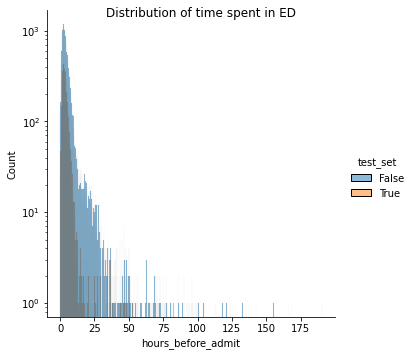

In [16]:
# visualize distribution
p = sns.displot(keep_visits,
               x='hours_before_admit',
                hue = 'test_set'
               )
p.fig.suptitle("Distribution of time spent in ED")
p.fig.get_axes()[0].set_yscale('log')
plt.show()

In [17]:
# look at time spent in ED for train and test sets
keep_visits.groupby('test_set').hours_before_admit.describe()

,count,mean,std,min,25%,50%,75%,max
test_set,,,,,,,,
False,31379.0,5.219968,7.153447,0.016667,2.250000,3.616667,5.683333,190.433333
True,10042.0,4.000407,4.124929,0.016667,2.233333,3.300000,4.733333,95.100000


In [18]:
# look at time spent in ED for entire cohort
keep_visits.hours_before_admit.describe()

count    41421.000000
mean         4.924300
std          6.569893
min          0.016667
25%          2.250000
50%          3.516667
75%          5.400000
max        190.433333
Name: hours_before_admit, dtype: float64